In [2]:
# HOME
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# get the code
import sys
sys.path.append('../scripts')
from codeCNV.plot import plot_snp, plot_2d, plot_3d
from codeCNV.rollingCNV import apply_rolling_SNP, interpolate, one_col_rolling

home = '/Users/mahtin'
home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV']['combine']
        return config
config = get_config(config_file)

# 
cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

## get the SNP data with FullExonPos

In [4]:
sample = "02_B"
snp_df = pd.read_csv(os.path.join(output_path, f'tmp/{sample}.snpcov.gz'), sep='\t', compression='gzip')

### run the code

In [7]:
snp2_df = apply_rolling_SNP(snp_df, config)
snp2_df.to_csv(os.path.join(output_path, f'CNV/{sample}.roll.snp'), sep='\t', index=False)

/Users/martinscience/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/martinscience/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### visualize the data

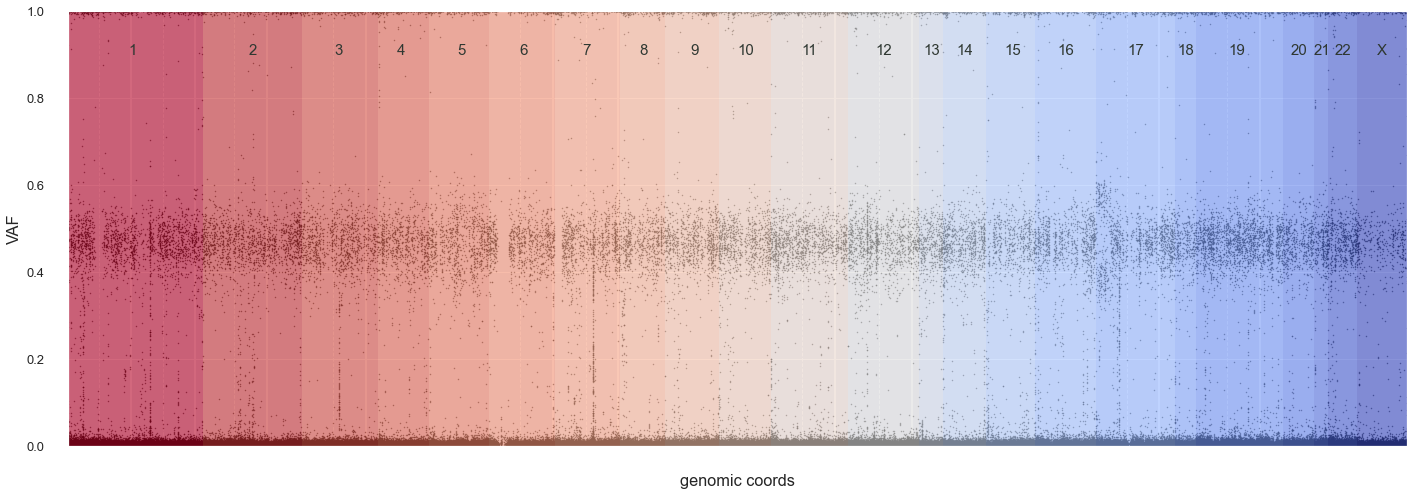

In [6]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vaf = dict(
        title='VAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            s=.2,
            color='black',
            alpha=.7
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp_df, snp_plots=[vaf], chroms='all', region='', **fig_params)

## heteroSNP rolling window
+ #### first, important local features have to be extracted:
    * absVAF: distance measure from the meanVAF
    * llh: log-likelihood to belong the center gaussian
    * deltaVAF: measure of relative spread of the data
+ #### next, these local features have to be computed with a rolling window to convert local to regional data

### extract important features from SNPdata
+ absVAF is distance of heteroSNP to mean
+ deltaVAF is difference between adjacent SNPs

In [8]:
def llh(data, mean, sigma):
    '''
    computes the loglikehood of samples in data under normal distribution
    defined by mean and sigma
    '''
    
    s = np.sqrt(2 * np.pi) * sigma
    return np.exp((data - mean)**2 / (-2*(sigma**2))) / s

def get_SNPllhs(df, config):
    '''
    computes the log-likelihoods of belonging to the center mass or the upper band (in case of high clonality)
    '''
    
    
    
    

def expand_SNPdata(snp_df, config):
    '''
    retrieve a few data columns locally to use rolling windows on
    this needs to be done chromosome-wise in order to avoid gap effects
    VAF limits are also applied here
    '''
        
    LLHOMOWINDOW = 50
    # split the params dict for easier access
    params = config['SNP']
    filter_params = params['filter']
    # data_params = params['data']
    
    # reduce the snp_df using lower config limit
    # upper limit has to be set later as we still need the homoSNP llh
    VAFmin, VAFmax = filter_params['VAF']
    df = snp_df.query('@VAFmin < VAF')
    
    # get the sigmas for llh computation
    sigma = params['sigma']
    # llhHomo later gives clues about purity > .95 edge case
    df.loc[:, 'llhHomo'] = llh(df['VAF'], 1, sigma['homoSNP'])
    # do the rolling window for llhHomo sum on mean < VAF to get homoSNP density without interference of drop traces
    
    # df['LLHomo'] can be done with the one_col rolling function easily
    filter_df = df.query('VAF > @mean')
    dfHomo['LLHomo'] = dfHomo['llhHomo'].rolling()
    
    
    # get the means from the SNP center band
    mean = df.query('0.4 < VAF < 0.6')['VAF'].mean()
    
    snp_df.loc[:, 'llh'] = llh(snp_df['VAF'], mean, sigma['heteroSNP'])
    

    
    # get the new features from VAFs
    snp_df.loc[:,'absVAF'] = np.abs(snp_df['VAF'] - mean) * 2
    # get the local VAF difference chrom based
    dfs = []
    for chrom in snp_df['Chr'].unique():
        chrom_df = snp_df.query('Chr == @chrom')
        chrom_df.loc[:, 'deltaVAF'] = np.abs(chrom_df['VAF'] - chrom_df.shift(1)['VAF']).fillna(0)
        dfs.append(chrom_df)
    snp_df = pd.concat(dfs).sort_values('FullExonPos')
    return snp_df.reset_index(drop=True)

In [ ]:
snp2_df = expand_SNPdata(snp_df, config)
snp2_df

In [ ]:
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0.02,1.05),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)


absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=2,
            alpha=1
        ))
deltavaf = dict(
        title='deltaVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='deltaVAF',
        plot_args=dict(
            linewidth=0.5,
            color='green',
            s=5,
            alpha=1
        ))

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp2_df, snp_plots=[absvaf], cov_plots=[log2, log2mean], chroms=chroms, region='', **fig_params)

## Rolling SNPdata

In [ ]:
from rollingCNV import one_col_rolling

def rolling_SNP(snp_df, config):
    '''
    cycle through the chroms and perform rolling window computations of snp data set in config
    '''
    
    # split the params dict for easier access
    params = config['heteroSNP']
    filter_params = params['filter']
    data_params = params['data']
    # reduce the snp_df using config limits
    VAFmin, VAFmax = filter_params['VAF'] 
    minDepth = filter_params['minDepth']
    minEBscore = filter_params['minEB']
    
    # cycle through chroms for 
    chrom_dfs = []
    for chrom in snp_df['Chr'].unique():
        # restrict to chrom
        chrom_df = snp_df.query('Chr == @chrom').sort_values('FullExonPos')        
        # filter df
        filter_df = snp_df.query('Depth >= @minDepth and EBscore > @minEBscore') #.query('@VAFmin < VAF < @VAFmax and 
        for data_col in data_params.keys():
            for agg in data_params[data_col].keys():
                window_size = data_params[data_col][agg]
                expand_limit = int(params['expand'] * window_size)
                # print(f"Computing rolling window for {agg} of {data_col} with window size {window_size} on {chrom}")
                chrom_df = one_col_rolling(chrom_df, filter_df, data_col, agg, window_size=window_size, expand_limit=expand_limit, normalize=params['normalize'], debug=config['debug'])
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    return df

### test rolling windows

In [ ]:
snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'mean': 20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)
snp3_df[:10]

## optimizing rolling windows

### VAF
+ std  (20)
+ var

In [ ]:
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))
vafvar = dict(
        title='VAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='VAFvar',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vafvardiff = dict(
        title='VAFstdDiff',
        plot_type='line',   # ['line', 'scatter']
        data='VAFvarDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

vafstd = dict(
        title='VAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='VAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vafstddiff = dict(
        title='VAFstdDiff',
        plot_type='line',   # ['line', 'scatter']
        data='VAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'VAF': {
                'var': 50,
                'std': 50
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

std_plots = [vaf,vafstd, vafstddiff]
var_plots = [vaf,vafvar, vafvardiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=std_plots, chroms=chroms, region='', **fig_params)

### absVAF
+ mean (20)
+ std

In [ ]:
absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))

absvafstd = dict(
        title='absVAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafstddiff = dict(
        title='absVAFstddiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )


absvafmean = dict(
        title='absVAFmean',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafmeandiff = dict(
        title='absVAFdiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.05
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'absVAF': {
                'mean': 50,
                'std': 50
            }
        }
    }   
}

config.update(snp_config)
config['ddof'] = 0

snp3_df = rolling_SNP(snp2_df, config)
print(len(snp3_df.query('Chr == "chr17"').index))
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
mean_plots = [absvaf,absvafmean, absvafmeandiff]
std_plots = [absvaf,absvafstd, absvafstddiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=mean_plots, chroms=chroms, region='chr17', **fig_params)

### deltaVAF
+ mean
+ var (20)
+ std 

In [ ]:
deltavafstd = dict(
        title='deltaVAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

deltavafstddiff = dict(
        title='deltaVAFstddiff',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

deltavaf = dict(
        title='deltaVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='deltaVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))
deltavafmean = dict(
        title='deltaVAFmean',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFmean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

deltavafmeandiff = dict(
        title='deltaVAFmeandiff',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFmeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

deltavafvar = dict(
        title='deltaVAFvar',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvar',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

deltavafvardiff = dict(
        title='deltaVAFvardiff',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvarDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

snp_config = {
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=10,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': .75,
        'data': {
            'deltaVAF': {
                'var': 20,
                'std': 20
            }
        }
    }   
}

config.update(snp_config)
snp3_df = rolling_SNP(snp2_df, config)

mean_plots = [deltavaf,deltavafmean, deltavafmeandiff]
std_plots = [deltavaf,deltavafstd, deltavafstddiff]
var_plots = [deltavaf,deltavafvar, deltavafvardiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=var_plots, chroms=chroms, region='', **fig_params)

## bring all together
+ center snp_df
+ get extra data
+ do the rolling

In [ ]:
def apply_rolling_SNP(snp_df, config):
    # center the data
    snp_df = center_data(snp_df, config)
    # get extra data
    snp_df = expand_SNPdata(snp_df, config)
    # do the rolling
    snp_df = rolling_SNP(snp2_df, config)
    return snp_df

In [ ]:
config = {
    'debug': False, # also export the left and right rolling window values (L/R)
    'coverage': {
        'filter': dict(
            min_cov = 30,
            min_PON_cov = 50,
            max_PON_std = 100,
        ),
        'normalize':False,
        'center': True,
        'expand':0.2, # after interpolation of rolling data from filtered df into full df, interpolate missing data within this fraction of window size, set 0 if no interpolation is wanted
        'data': {
            'log2ratio': {
                'mean':100
            }
        }
    },
    'heteroSNP': {
        'filter': dict(
            VAF=(0.05,0.95),
            minDepth=30,
            minEB=0.5
        ),
        'normalize': True,
        'center':False,
        'expand': 0.5,
        'data': {
            'absVAF': {
                'mean': 20
            },
            'VAF': {
                'std': 20
            },
            'deltaVAF': {
                'var': 20,
                'std': 20
            }
        }
    }
}

rSNP_df = apply_rolling_SNP(snp_df, config)

In [ ]:
rSNP_df